In [25]:
import cupy as cp
import numpy as np
import matplotlib.pyplot as plt

# Performance-optimized CuPy implementation
# Complements the didactic pure Python version with GPU acceleration

def wolfram_bits(rule: int) -> cp.ndarray:
    """GPU version: Return rule bits in Wolfram order."""
    if not (0 <= rule < 256):
        raise ValueError("rule must be in [0, 255]")
    as_str = f"{rule:08b}"
    return cp.array([c == "1" for c in as_str], dtype=bool)


def selector_tensor() -> cp.ndarray:
    """GPU version: Build selector tensor S ∈ Bool^{8×3×2}."""
    patterns = cp.array([
        [1,1,1], [1,1,0], [1,0,1], [1,0,0],
        [0,1,1], [0,1,0], [0,0,1], [0,0,0]
    ], dtype=bool)
    S = cp.zeros((8, 3, 2), dtype=bool)
    for k in range(8):
        for r in range(3):
            S[k, r, int(patterns[k, r])] = True
    return S


class ECA:
    """
    Performance-optimized Elementary Cellular Automaton for GPU.

    Design philosophy: Maximize throughput for large n and long runs.
    - Pre-allocates tensors where possible
    - Fuses operations to reduce kernel launches
    - Optimizes memory access patterns
    - Provides both fused and unfused APIs

    Complements the pure Python pedagogical version.
    """

    # Class-level GPU constants
    _S = None

    def __init__(self, rule: int):
        self.rule = rule
        self.name = f"Rule {rule}"
        self.bits = wolfram_bits(rule)

        # Initialize class constants if needed
        if ECA._S is None:
            ECA._S = selector_tensor()

    # ----- OPTIMIZED CORE: FUSED OPERATIONS -----

    def iterate_fused(self, x: cp.ndarray, workspace: dict = None) -> cp.ndarray:
        """
        Optimized single step: fuses map→lift→reduce into minimal operations.
        Uses pre-allocated workspace tensors when provided.

        This is the performance-critical path for long simulations.
        """
        n = x.shape[0]

        # Get or allocate workspace
        if workspace is None:
            y = cp.empty((n, 3), dtype=bool)
        else:
            y = workspace.get('y', cp.empty((n, 3), dtype=bool))

        # Fused map: direct neighborhood indexing (faster than tensor contraction)
        y[:, 0] = x[cp.arange(n) - 1]  # left neighbors (wraps)
        y[:, 1] = x                     # self
        y[:, 2] = x[cp.arange(n) + 1]   # right neighbors (wraps with mod)
        y[:, 2] = cp.where(cp.arange(n) == n-1, x[0], y[:, 2])  # fix wrap

        # Fused lift→reduce: avoid materializing full z matrix
        x_next = cp.zeros(n, dtype=bool)

        # Process each pattern directly (more cache-friendly than full broadcast)
        patterns = cp.array([
            [1,1,1], [1,1,0], [1,0,1], [1,0,0],
            [0,1,1], [0,1,0], [0,0,1], [0,0,0]
        ], dtype=bool)

        for k in range(8):
            if self.bits[k]:  # Only process if rule bit is set
                # Find cells matching pattern k
                match = cp.all(y == patterns[k], axis=1)
                x_next |= match

        return x_next

    def run_optimized(self, x0: cp.ndarray, steps: int,
                     return_trajectory: bool = True) -> cp.ndarray:
        """
        High-performance simulation with minimal allocations.

        Parameters
        ----------
        x0 : cp.ndarray
            Initial state
        steps : int
            Number of time steps
        return_trajectory : bool
            If False, returns only final state (saves memory)
        """
        n = x0.shape[0]
        x = x0.copy()

        # Pre-allocate workspace for reuse
        workspace = {'y': cp.empty((n, 3), dtype=bool)}

        if return_trajectory:
            X = cp.empty((steps, n), dtype=bool)
            X[0] = x
            for t in range(1, steps):
                x = self.iterate_fused(x, workspace)
                X[t] = x
            return X
        else:
            # Memory-efficient: don't store trajectory
            for _ in range(steps):
                x = self.iterate_fused(x, workspace)
            return x

    # ----- PEDAGOGICAL API (matches pure Python) -----

    @staticmethod
    def get_neighborhoods(n: int) -> cp.ndarray:
        """Build topology tensor C ∈ Bool^{n×3×n}."""
        C = cp.zeros((n, 3, n), dtype=bool)
        for i in range(n):
            C[i, 0, (i - 1) % n] = True
            C[i, 1, i] = True
            C[i, 2, (i + 1) % n] = True
        return C

    @staticmethod
    def map(x: cp.ndarray, C: cp.ndarray = None) -> cp.ndarray:
        """Stage 1: Gather neighborhoods."""
        n = x.shape[0]
        if C is None:
            C = ECA.get_neighborhoods(n)
        return cp.any(C & x[None, None, :], axis=2)

    def lift(self, y: cp.ndarray) -> cp.ndarray:
        """Stage 2: One-hot encode patterns."""
        y_pm = cp.stack([~y, y], axis=2)
        H = y_pm[:, None, :, :] & self._S[None, :, :, :]
        G = cp.any(H, axis=3)
        z = cp.all(G, axis=2)
        return z

    def reduce(self, z: cp.ndarray) -> cp.ndarray:
        """Stage 3: Apply rule bits."""
        return cp.any(z & self.bits[None, :], axis=1)

    def reduce_from_neighborhoods(self, y: cp.ndarray) -> cp.ndarray:
        """Convenience: reduce(lift(y))."""
        return self.reduce(self.lift(y))

    def iterate(self, x: cp.ndarray, C: cp.ndarray = None) -> cp.ndarray:
        """Pedagogical version: explicit map→lift→reduce composition."""
        y = self.map(x, C)
        z = self.lift(y)
        return self.reduce(z)

    def run(self, x0: cp.ndarray, steps: int, C: cp.ndarray = None) -> cp.ndarray:
        """Pedagogical version using explicit composition."""
        n = x0.shape[0]
        if C is None:
            C = self.get_neighborhoods(n)

        X = cp.zeros((steps, n), dtype=bool)
        x = x0.copy()
        for t in range(steps):
            X[t] = x
            x = self.iterate(x, C)
        return X

    # ----- UTILITIES -----

    @staticmethod
    def get_random_state(n: int, p: float = 0.5) -> cp.ndarray:
        """Random state with P(True)=p."""
        return cp.random.rand(n) < p

    def benchmark(self, n: int, steps: int, trials: int = 5) -> dict:
        """
        Performance comparison between fused and unfused implementations.
        Returns timing statistics.
        """
        import time

        results = {'n': n, 'steps': steps, 'trials': trials}

        # Warm up GPU
        x0 = self.get_random_state(n)
        _ = self.iterate_fused(x0)
        cp.cuda.Device().synchronize()

        # Benchmark fused version
        times_fused = []
        for _ in range(trials):
            x0 = self.get_random_state(n)
            cp.cuda.Device().synchronize()
            start = time.perf_counter()
            _ = self.run_optimized(x0, steps, return_trajectory=False)
            cp.cuda.Device().synchronize()
            times_fused.append(time.perf_counter() - start)

        # Benchmark unfused version
        times_unfused = []
        C = self.get_neighborhoods(n)
        for _ in range(trials):
            x0 = self.get_random_state(n)
            cp.cuda.Device().synchronize()
            start = time.perf_counter()
            x = x0.copy()
            for _ in range(steps):
                x = self.iterate(x, C)
            cp.cuda.Device().synchronize()
            times_unfused.append(time.perf_counter() - start)

        results['fused_mean'] = np.mean(times_fused)
        results['fused_std'] = np.std(times_fused)
        results['unfused_mean'] = np.mean(times_unfused)
        results['unfused_std'] = np.std(times_unfused)
        results['speedup'] = results['unfused_mean'] / results['fused_mean']

        return results

    # ----- CONVERSION UTILITIES -----

    def to_numpy(self, x: cp.ndarray) -> np.ndarray:
        """Transfer from GPU to CPU."""
        return cp.asnumpy(x)

    def from_numpy(self, x: np.ndarray) -> cp.ndarray:
        """Transfer from CPU to GPU."""
        return cp.asarray(x)

    # ----- VISUALIZATION (converts to numpy) -----

    def __repr__(self) -> str:
        patterns = ["111","110","101","100","011","010","001","000"]
        bits_cpu = self.bits.get()
        mapping = ", ".join(f"{p}→{int(b)}" for p, b in zip(patterns, bits_cpu))
        return f"<ECA {self.rule}: {mapping}>"

    def plot_truth_table(self) -> None:
        """Bar plot of rule outputs."""
        bits_cpu = self.bits.get()
        fig, ax = plt.subplots()
        ax.bar(range(8), bits_cpu.astype(int))
        ax.set_xticks(range(8), ["111","110","101","100","011","010","001","000"], rotation=45)
        ax.set_ylim(-0.05, 1.05)
        ax.set_title(f"Truth table for {self.name}")
        ax.set_ylabel("Output bit")
        plt.show()

    def space_time(self, x0: cp.ndarray, steps: int = 64,
                   use_optimized: bool = True) -> None:
        """Plot space-time diagram."""
        if use_optimized:
            X = self.run_optimized(x0, steps)
        else:
            X = self.run(x0, steps)

        # Convert to CPU for plotting
        X_cpu = X.get().astype(int)
        n = X_cpu.shape[1]

        fig_width = max(6, n / 10)
        fig_height = max(3, steps / 10)
        fig, ax = plt.subplots(figsize=(fig_width, fig_height))
        ax.imshow(X_cpu, aspect="auto")
        ax.set_xlabel("Cell index")
        ax.set_ylabel("Time step")
        ax.set_title(f"Space-time diagram for {self.name}")
        plt.show()

    def random_demo(self, n: int, steps: int = 60, use_optimized: bool = True) -> None:
        """Quick demo with random initial condition."""
        x0 = self.get_random_state(n)
        self.space_time(x0, steps, use_optimized=use_optimized)


# ----- BATCH PROCESSING FOR MULTIPLE RULES -----

class ECABatch:
    """
    Process multiple ECA rules in parallel on GPU.
    Useful for parameter sweeps and comparative studies.
    """

    def __init__(self, rules: list[int]):
        self.rules = rules
        self.ecas = [ECA(rule) for rule in rules]
        self.n_rules = len(rules)

    def run_parallel(self, x0: cp.ndarray, steps: int) -> cp.ndarray:
        """
        Run multiple rules on the same initial condition.
        Returns shape (n_rules, steps, n).
        """
        n = x0.shape[0]
        results = cp.empty((self.n_rules, steps, n), dtype=bool)

        for i, eca in enumerate(self.ecas):
            results[i] = eca.run_optimized(x0, steps)

        return results

    def compare_rules(self, x0: cp.ndarray, steps: int = 50) -> None:
        """Visualize multiple rules side by side."""
        results = self.run_parallel(x0, steps)
        results_cpu = results.get().astype(int)

        n_rules = len(self.rules)
        fig, axes = plt.subplots(1, n_rules, figsize=(4*n_rules, 6))
        if n_rules == 1:
            axes = [axes]

        for i, (rule, ax) in enumerate(zip(self.rules, axes)):
            ax.imshow(results_cpu[i], aspect="auto")
            ax.set_title(f"Rule {rule}")
            ax.set_xlabel("Cell")
            if i == 0:
                ax.set_ylabel("Time")

        plt.tight_layout()
        plt.show()

In [26]:
rule20 = ECA(20)

In [30]:
rule20

<ECA 20: 111→0, 110→0, 101→0, 100→1, 011→0, 010→1, 001→0, 000→0>

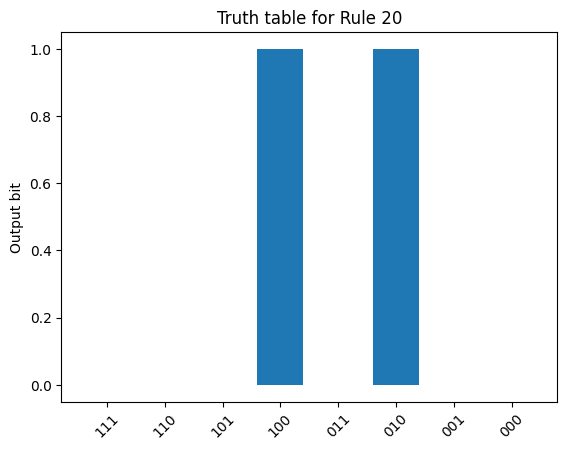

In [31]:
rule20.plot_truth_table()

In [29]:
# Pedagogical API (matches your pure Python)
x = rule20.get_random_state(100)
y = rule20.map(x)
z = rule20.lift(y)
x_next = rule20.reduce(z)

In [34]:
# Performance API
x_next = rule20.iterate_fused(x)
print(x_next)

[False False False  True  True False False False False False False False
  True False False False False False  True False False False False False
  True False False False  True  True False False False False  True False
 False False False False  True False  True  True False False  True False
 False False False False False False False False False False  True False
 False  True  True False  True  True False False False False False  True
 False  True False  True False False False False False False False  True
 False  True  True False  True False False False False False False False
 False False False False]


In [32]:
steps = 100

In [35]:
X = rule20.run_optimized(x, steps, return_trajectory=True)
print(X)

[[ True  True False ...  True  True  True]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [ True False False ... False False  True]
 [False  True False ... False False False]
 [False  True  True ... False False False]]


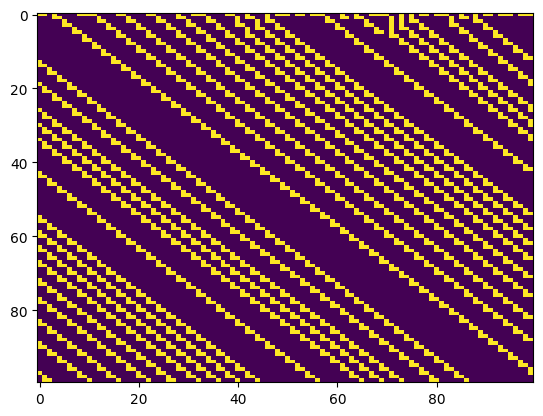

In [36]:
X_np = X.get()
plt.imshow(X_np, aspect="auto")
plt.show()

In [37]:
rule20.random_demo(1000,1000)

In [38]:
rule30 = ECA(30)

In [39]:
rule30

<ECA 30: 111→0, 110→0, 101→0, 100→1, 011→1, 010→1, 001→1, 000→0>

In [40]:
rule30.random_demo(1000,1000)

In [41]:
rule110 = ECA(110)

In [42]:
rule110

<ECA 110: 111→0, 110→1, 101→1, 100→0, 011→1, 010→1, 001→1, 000→0>

In [43]:
rule110.random_demo(1000,1000)